In [ ]:
#!pip install --upgrade pip setuptools wheel
!pip install git+https://github.com/HumanCompatibleAI/overcooked_ai.git
!pip install Pillow
!pip install matplotlib
!pip install IPython
!pip install torch

In [2]:
### Imports ###

from overcooked_ai_py.mdp.overcooked_mdp import OvercookedGridworld
from overcooked_ai_py.mdp.overcooked_env import OvercookedEnv
from overcooked_ai_py.agents.benchmarking import AgentEvaluator
from overcooked_ai_py.visualization.state_visualizer import StateVisualizer
from overcooked_ai_py.agents.agent import NNPolicy, AgentFromPolicy, AgentPair
import gym
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import display, HTML

import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import pdb

In [3]:
import torch
from PIL import Image
import os
from IPython.display import display, Image as IPImage
# from google.colab import drive

In [5]:
# Project 2 Deep SARSA
# We modify it to be DQN because it makes more sense to be off-policy
# Adding an experience buffer to be more efficient with episodes

class NN(nn.Module):
    def __init__(self, hidden_size):
        super(NN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(96, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 6))

    def forward(self, x):
        return self.network(x)

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)
    
class DeepQL(object):
    def __init__(self, env, alpha=0.01, gamma=0.98, 
                 epsilon=1.0, epsilon_decay=0.99, min_epsilon=0.01, 
                 hidden_size=128, max_iter=1000, buffer_size=10000, batch_size=64):
        self.Q = None
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.env = env
        self.tot_rewards = []
        self.soups_made = []
        self.max_iter = max_iter
        self.min_epsilon = min_epsilon
        self.replay_buffer = ReplayBuffer(buffer_size)

        # NN params
        self.q_network = NN(hidden_size)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=alpha)

    def solve(self):
        iters = 0
        converged = False
        torch.manual_seed(3)
        np.random.seed(3)
        while iters < self.max_iter:
            done = False
            num_soups_made = 0
            tot_reward = 0 
            state = self.env.reset()

            while not done:
                state0 = state['both_agent_obs'][0]
                state1 = state['both_agent_obs'][1]
                a0 = self.next_move(state0)
                a1 = self.next_move(state1)

                new_state, reward, done, info = self.env.step([a0,a1])
                agent_0_reward = info["shaped_r_by_agent"][0] + reward
                agent_1_reward = info["shaped_r_by_agent"][1] + reward
                num_soups_made += int(reward / 20) # rewards are totaled

                tot_reward += agent_0_reward + agent_1_reward + reward
                new_state0 = new_state['both_agent_obs'][0]
                new_state1 = new_state['both_agent_obs'][1]
                
                self.replay_buffer.push(state0, a0, agent_0_reward, new_state0, done)
                self.replay_buffer.push(state1, a1, agent_1_reward, new_state1, done)
                
                if len(self.replay_buffer) > self.batch_size:
                    experiences = self.replay_buffer.sample(self.batch_size)
                    self.learn_from_experiences(experiences)

                state = new_state
            iters += 1
            self.soups_made.append(num_soups_made)
            self.tot_rewards.append(tot_reward)
            # decay epsilon
            self.epsilon = max(self.epsilon_decay * self.epsilon, self.min_epsilon)

            # update on training
            if iters % 100 == 0:
                print('finished ', iters ,' iterations', 'made soups: ', np.mean(self.soups_made[-100:]))
                print('tot reward:', np.mean(self.tot_rewards[-100:]))
            if iters % 1000 == 0:
                plt.plot(self.tot_rewards)
                plt.ylabel('Episode Reward')
                plt.xlabel('Episodes')
                plt.show()
    
    def next_move(self, state):
        ''' returns epsilon greedy move given an np.array state'''
        state = torch.FloatTensor(state).unsqueeze(0)
        # set the action based on epsilon greedy
        if np.random.random() < self.epsilon:
            return(self.env.action_space.sample())
        else:
            # calculate the argmax using torch
            with torch.no_grad():
                q_values = self.q_network(state)
                return(torch.argmax(q_values).item())
        
    def optimal_move(self, state):
        ''' return optimal next move given an np.array state'''
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.q_network(state)
            return(torch.argmax(q_values).item())
        
    def learn_from_experiences(self, experiences):
        # Unpack experiences and convert them to tensor
        states, actions, rewards, next_states, dones = zip(*experiences)
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        # Compute Q values for current states
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Compute Q values for next states
        next_q_values = self.q_network(next_states).detach().max(1)[0]
        next_q_values[dones] = 0  # Zero out Q-values where done is true

        # Compute the target Q values
        target_q_values = rewards + self.gamma * next_q_values

        # Compute loss and backpropagate
        loss = F.mse_loss(current_q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [6]:
### Environment setup ###

# Swap between the 5 layouts here:
layout = "cramped_room"
# layout = "asymmetric_advantages"
# layout = "coordination_ring"
# layout = "forced_coordination"
# layout = "counter_circuit_o_1order"

# Reward shaping is disabled by default.  This data structure may be used for
# reward shaping.  You can, of course, do your own reward shaping in lieu of, or
# in addition to, using this structure.
reward_shaping = {
    "PLACEMENT_IN_POT_REW": 2,
    "DISH_PICKUP_REWARD": 3,
    "SOUP_PICKUP_REWARD": 4
}

# Length of Episodes.  Do not modify for your submission!
# Modification will result in a grading penalty!
horizon = 400

# Build the environment.  Do not modify!
mdp = OvercookedGridworld.from_layout_name(layout, rew_shaping_params=reward_shaping)
base_env = OvercookedEnv.from_mdp(mdp, horizon=horizon, info_level=0)
env = gym.make("Overcooked-v0", base_env=base_env, featurize_fn=base_env.featurize_state_mdp)

TypeError: object.__new__() takes exactly one argument (the type to instantiate)

finished  100  iterations made soups:  0.0
tot reward: 5.73
finished  200  iterations made soups:  0.0
tot reward: 5.53
finished  300  iterations made soups:  0.0
tot reward: 2.54
finished  400  iterations made soups:  0.0
tot reward: 0.64
finished  500  iterations made soups:  0.0
tot reward: 1.23
finished  600  iterations made soups:  0.0
tot reward: 1.27
finished  700  iterations made soups:  0.0
tot reward: 1.17
finished  800  iterations made soups:  0.0
tot reward: 1.21
finished  900  iterations made soups:  0.0
tot reward: 1.0
finished  1000  iterations made soups:  0.0
tot reward: 1.1


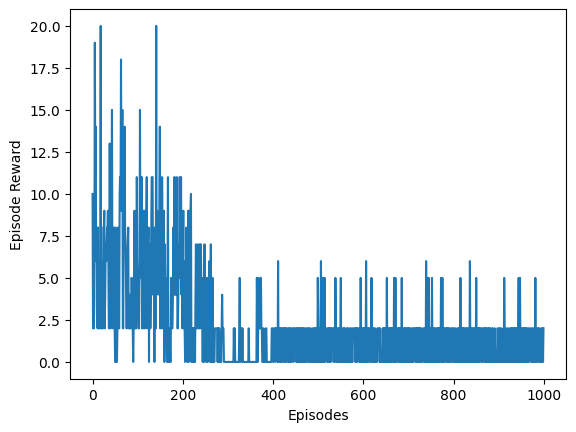

In [95]:
a = DeepSarsa(env, alpha=0.001, gamma=0.99, 
             epsilon=0.99, epsilon_decay=0.99, min_epsilon=0.01, 
             hidden_size=128, max_iter=1000)
a.solve()

In [ ]:
a.q_network.state_dict()

In [44]:
### Train your agent ###

# The code below runs a few episodes with a random agent.  Your learning algorithm
# would go here.

num_episodes = 5
torch.manual_seed(3)
np.random.seed(3)
for e in range(num_episodes):
    # Episode termination flag
    done = False

    # The number of soups the agent pair made during the episode
    num_soups_made = 0

    # Reset the environment at the start of each episode
    obs = env.reset()

    while not done:
        # Obtain observations for each agent
        obs0 = obs["both_agent_obs"][0]
        obs1 = obs["both_agent_obs"][1]
        # Select random actions from the set {North, South, East, West, Stay, Interact}
        # for each agent.
        
        
        a0 = env.action_space.sample()
        a1 = env.action_space.sample()

        # Take the selected actions and receive feedback from the environment
        # The returned reward "R" only reflects completed soups.  You can find
        # the separate shaping rewards in the "info" variables
        # info["shaped_r_by_agent"][0] and info["shaped_r_by_agent"][1].  Note that
        # this shaping reward does *not* include the +20 reward for completed
        # soups returned in "R".
        obs, R, done, info = env.step([a0, a1])
        if env.agent_idx == 0:
            agent_0_reward = info["shaped_r_by_agent"][0] + R
        if env.agent_idx == 1:
            agent_0_reward = info["shaped_r_by_agent"][1] + R
        # Accumulate the number of soups made
        num_soups_made += int(R / 20) # Each served soup generates 20 reward

    # Display status
    print("Ep {0}".format(e + 1), end=" ")
    print("number of soups made: {0}".format(num_soups_made))

# The info flag returned by the environemnt contains special status info
# specifically when done == True.  This information may be useful in
# developing, debugging, and analyzing your results.  It may also be a good
# way for you to find a metric that you can use in evaluating collaboration
# between your agents.
print("\nExample info dump:\n\n", info)

SyntaxError: expected ':' (3931249060.py, line 37)

In [100]:
env.agent_idx

1

In [ ]:
state = env.reset()

In [111]:
env.featurize_state_mdp(state)

AttributeError: 'Overcooked' object has no attribute 'featurize_state_mdp'

In [87]:
### Evaluate your agent ###

# This is where you would rollout episodes with your trained agent.
# The below code is a partcular way to rollout episodes in a format
# compatible with a state visualizer, if you'd like to visualize what your
# agents are doing during episodes.  Visualization is in the next cell.

class StudentPolicy(NNPolicy):
    """ Generate policy """
    def __init__(self):
        super(StudentPolicy, self).__init__()

    def state_policy(self, state, agent_index):
        """
        This method should be used to generate the poiicy vector corresponding to
        the state and agent_index provided as input.  If you're using a neural
        network-based solution, the specifics depend on the algorithm you are using.
        Below are two commented examples, the first for a policy gradient algorithm
        and the second for a value-based algorithm.  In policy gradient algorithms,
        the neural networks output a policy directly.  In value-based algorithms,
        the policy must be derived from the Q value outputs of the networks.  The
        uncommented code below is a placeholder that generates a random policy.
        """
        featurized_state = base_env.featurize_state_mdp(state)
        input_state = torch.FloatTensor(featurized_state[agent_index]).unsqueeze(0)
        # Example for policy NNs named "PNN0" and "PNN1"
        # with torch.no_grad():
        #   if agent_index == 0:
        #       action_probs = PNN0(input_state)[0].numpy()
        #   else:
        #       action_probs = PNN1(input_state)[0].numpy()

        # Example for Q value NNs named "QNN0" and "QNN1"
        # action_probs = np.zeros(env.action_space.n)
        # with torch.no_grad():
        #   if agent_index == 0:
        #       action_probs[np.argmax(QNN0(input_state)[0].numpy())] = 1
        #   else:
        #       action_probs[np.argmax(QNN1(input_state)[0].numpy())] = 1

        # Random deterministic policy
        action = a.optimal_move(featurized_state[agent_index])

        action_probs = np.zeros(env.action_space.n)
        action_probs[action] = 1
        return action_probs

    def multi_state_policy(self, states, agent_indices):
        """ Generate a policy for a list of states and agent indices """
        return [self.state_policy(state, agent_index) for state, agent_index in zip(states, agent_indices)]


class StudentAgent(AgentFromPolicy):
    """Create an agent using the policy created by the class above"""
    def __init__(self, policy):
        super(StudentAgent, self).__init__(policy)


# Instantiate the policies for both agents
policy0 = StudentPolicy()
policy1 = StudentPolicy()

# Instantiate both agents
agent0 = StudentAgent(policy0)
agent1 = StudentAgent(policy1)
agent_pair = AgentPair(agent0, agent1)

# Generate an episode
ae = AgentEvaluator.from_layout_name({"layout_name": layout}, {"horizon": horizon})
trajs = ae.evaluate_agent_pair(agent_pair, num_games=1)
print("\nlen(trajs):", len(trajs))

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Computing MotionPlanner to be saved in C:\Users\brand\miniconda3\envs\rl3\Lib\site-packages\overcooked_ai_py\data\planners\cramped_room_mp.pkl
It took 0.05194282531738281 seconds to create mp


Avg rew: 0.00 (std: 0.00, se: 0.00); avg len: 400.00; : 100%|████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


len(trajs): 10


In [88]:
### Agent Visualization ###

##############################################################################
# The function StateVisualizer() below generates images for the state of the
# environment at each time step of the episode.
#
# You have several options for how to use these images:
#
# 1) You can set img_dir to a local directory (or a directory within Google Drive
# if using Colab), and all the images will be saved to that directory for you to browse.
#
# 2) If using a notebook, you can set the argument ipthon_display=True to get a
# tool with a slider that lets you scan through all the images directly in the
# notebook.  This option does not require you to store your images.
#
# 3) You can generate a GIF of the episode. This requires you to set
# img_dir.  The code to generate the GIF is commented out below

# Modify as appropriate
img_dir = None
ipython_display = True
gif_path = None

# Do not modify -- uncomment for GIF generation
StateVisualizer().display_rendered_trajectory(trajs, img_directory_path=img_dir, ipython_display=ipython_display)
#img_list = [f for f in os.listdir(img_dir) if f.endswith('.png')]
#img_list.sort(key=lambda x: os.path.getmtime(os.path.join(img_dir, x)))
#images = [Image.open(img_dir + img).convert('RGBA') for img in img_list]
# images[0].save(gif_path, save_all=True, append_images=images[1:], optimize=False, duration=250, loop=0)
# with open(gif_path,'rb') as f: display(IPImage(data=f.read(), format='png'))

interactive(children=(IntSlider(value=0, description='timestep', max=399), Output()), _dom_classes=('widget-in…

In [7]:
for key in trajs:
  print(key)

ep_actions
ep_infos
ep_states
ep_lengths
ep_returns
mdp_params
ep_dones
env_params
metadatas
ep_rewards


In [14]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cd  %clear  %cls  %code_wrap  %colors  %conda  %config  %connect_info  %copy  %ddir  %debug  %dhist  %dirs  %doctest_mode  %echo  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %macro  %magic  %matplotlib  %mkdir  %more  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %ren  %rep  %rerun  %reset  %reset_selective  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%cmd  %%code_wrap  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  

In [15]:
pip list

Package               Version
--------------------- ------------
aiofiles              22.1.0
aiosqlite             0.18.0
anyio                 3.5.0
argon2-cffi           21.3.0
argon2-cffi-bindings  21.2.0
asttokens             2.0.5
attrs                 23.1.0
Babel                 2.11.0
backcall              0.2.0
beautifulsoup4        4.12.2
bleach                4.1.0
Brotli                1.0.9
certifi               2023.7.22
cffi                  1.15.1
charset-normalizer    2.0.4
cloudpickle           3.0.0
colorama              0.4.6
comm                  0.1.2
cryptography          41.0.3
debugpy               1.6.7
decorator             5.1.1
defusedxml            0.7.1
dill                  0.3.7
entrypoints           0.4
executing             0.8.3
Farama-Notifications  0.0.4
fastjsonschema        2.16.2
filelock              3.13.1
fsspec                2023.10.0
gym                   0.26.2
gym-notices           0.0.8
gymnasium             0.29.1
idna                